# Libraries and Data

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV
import skopt
import warnings
import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [136]:
warnings.filterwarnings("ignore", 'This pattern has match groups')

In [137]:
train = pd.read_csv("../data/advanced_train.csv", low_memory = False)
test = pd.read_csv("../data/advanced_test.csv", low_memory = False)
sample = pd.read_csv("../data/sample_submission.csv", low_memory = False)

In [138]:
train.shape, test.shape

((37439, 40), (10000, 39))

In [139]:
train.columns, test.columns

(Index(['Id', 'Sold Price', 'Summary', 'Type', 'Year built', 'Heating',
        'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
        'Total interior livable area', 'Total spaces', 'Garage spaces',
        'Region', 'Elementary School', 'Elementary School Score',
        'Elementary School Distance', 'Middle School', 'Middle School Score',
        'Middle School Distance', 'High School', 'High School Score',
        'High School Distance', 'Flooring', 'Heating features',
        'Cooling features', 'Appliances included', 'Laundry features',
        'Parking features', 'Tax assessed value', 'Annual tax amount',
        'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
        'Zip', 'State'],
       dtype='object'),
 Index(['Id', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling', 'Parking',
        'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
        'Total interior livable area', 'Total spaces', 'Garage spaces',
        'Region',

In [140]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37439 entries, 0 to 37438
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           37439 non-null  int64  
 1   Sold Price                   37439 non-null  int64  
 2   Summary                      37176 non-null  object 
 3   Type                         37439 non-null  object 
 4   Year built                   36686 non-null  float64
 5   Heating                      32481 non-null  object 
 6   Cooling                      29109 non-null  object 
 7   Parking                      36720 non-null  object 
 8   Lot                          26041 non-null  float64
 9   Bedrooms                     35235 non-null  object 
 10  Bathrooms                    34786 non-null  float64
 11  Full bathrooms               31696 non-null  float64
 12  Total interior livable area  35443 non-null  float64
 13  Total spaces    

# Data Exploration

## Training Data Cleansing

### Prices
Manual adjustments to list price to make the data more reasonable

In [154]:
train["Last Sold Price"] = np.where((train["Last Sold Price"] / train["Sold Price"] > 10) |
                                     (train["Last Sold Price"] / train["Sold Price"] < 0.1),
                                     0,
                                     train["Last Sold Price"])

In [155]:
train["Listed Price"] = np.where((train["Listed Price"] / train["Sold Price"] > 10) |
                                  (train["Listed Price"] / train["Sold Price"] < 0.1),
                                 0,
                                 train["Listed Price"])

## High School

In [9]:
#sns.histplot(np.log(train["Sold Price"]))
#sns.histplot(train["Garage spaces"])
#train["Year built"].unique()
train["High School Distance"].isna().any()

True

## Heating

In [10]:
asdf = train["Heating"].value_counts()
asdf

Central                                            7280
Central Forced Air                                 4695
Central Forced Air - Gas                           3041
Forced Air                                         1977
Wall Furnace                                       1535
                                                   ... 
Stove - Wood, Other                                   1
Radiant, Daiken Mini Splits                           1
Solar, Central Forced Air - Gas, Radiant Floors       1
Propane, Electric, Wall Furnace, Wood Stove           1
Natural Gas, Electric                                 1
Name: Heating, Length: 1536, dtype: int64

In [11]:
heat_types = train["Heating"].str.lower().str.split(",").explode().str.strip().value_counts()
heat_types.head(30)
# h1 = central, forced air, forced, furnace
# h2 = radiant, heat pump, baseboard, steam, zone
# h3 = wood, stove, fireplace, fire, coal, pellet
# h4 = solar, geothermal

central                     9195
forced air                  5999
central forced air          5830
central forced air - gas    3969
gas                         3522
wall furnace                2150
other                       1667
electric                    1438
fireplace                    928
baseboard                    699
natural gas                  678
radiant                      671
heating - 2+ zones           652
propane                      631
fireplace(s)                 469
none                         453
wall                         424
floor furnace                422
heat pump                    365
wood stove                   339
solar                        284
propane / butane             230
radiant floors               219
zoned                        201
stove                        177
wood / pellet                172
stove - wood                 138
forced air - gas             120
see remarks                  117
individual room controls     102
Name: Heat

In [12]:
train["Heating features"].str.lower().str.split(",").explode().str.replace(" ", "").value_counts().shape

(60,)

## Parking

In [13]:
# Take a looka at the most common values in the parking variable.
# 156 unique values in the parking variable
parking_types_train = train["Parking"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()

parking_types_train.head(40)
parking_types_train.index


Index(['garage', 'covered', 'garage-attached', 'driveway', 'carport',
       'garagedooropener', '0spaces', 'sidebyside', 'attached',
       'garage-detached',
       ...
       'over20spaces', 'drivethrugarage', 'uncoveredparkspaces2+',
       'morethanonespace', 'rvparking', 'unc#3', 'detachedgarage',
       'uncoveredparkingspace', 'carports-2ormore', 'sinkingarage'],
      dtype='object', length=156)

In [14]:

for ptype in parking_types_train.index:
    print(ptype)
    train[ptype] = train["Parking"].str.lower().str.replace(" ", "").str.contains(ptype)
    

garage
covered
garage-attached
driveway
carport
garagedooropener
0spaces
sidebyside
attached
garage-detached
garage-twodoor
off-street
onsite(singlefamilyonly)
interioraccess
independent
assigned
onsite
concrete
communitystructure
tandem
gated
on-street
guest
garage-singledoor
enclosed
underground/basement
private
none
controlledentrance
directaccess
detachedcarport
onsite-mapped(condoonly)
onstreet
garagefacesfront
offstreet
underground
open
autodrivewaygate
parkingspace
attachedcarport
detached
garage-threedoor
rvaccess/parking
valet
mixed
paved
shareddriveway
oversized
circulardriveway
drivewaylevel
built-instorage
convertedgarage
gravel
boat
driveway-combination
rvpotential
other
onsite-unassigned(condoonly)
rv
oversizedparking
workshopingarage
garagefacesrear
nogarage
garagefacesside
2cargarage
drivewaydownslopefromstreet
intaccessfromgarage
drivewayupslopefromstreet
mechanicallift
seeremarks
potentialrvparking
tandemcovered
sideyardaccess
asphalt
autoopener
sizelimited
rv/boatpar

/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


rvgarage
storage
unassigned
offsite
tandemuncovered
public
golfcartgarage
additionalcarport
pull-through
utilitysink
rvcovered
structure
rotational
additionalgarage
nodriveway
secured
gar#1
electricvehiclechargingstation(s)
overheightgarage
insideentrance
drivethru
unc#2
gar#3
guestspace(s)
noparkingonsite
two
notassigned
drivethrough
3cargarage
1cargarage
3ormoreparkingsp
2parkingspaces
rvpossible
4+cargarage
offstreetparking
remote
heatedgarage
cpt#1
insulated
streetparking
gar#4
one
1-10spaces
undersizedgarage
rvaccess
manualdoor
cpt#2
over20spaces
drivethrugarage
uncoveredparkspaces2+
morethanonespace
rvparking
unc#3
detachedgarage
uncoveredparkingspace
carports-2ormore
sinkingarage


## Lot

<AxesSubplot:>

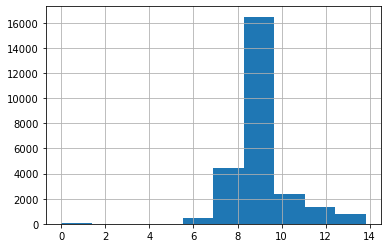

In [15]:
np.log(np.minimum(train["Lot"], 1e6) + 1).hist()

In [16]:
train[train["Lot"].isna()]

,Id,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,...,over20spaces,drivethrugarage,uncoveredparkspaces2+,morethanonespace,rvparking,unc#3,detachedgarage,uncoveredparkingspace,carports-2ormore,sinkingarage
1,1,711000,"Modern, Hip, & Bright! This beautifully mainta...",Condo,2016.0,Central,"Air Conditioning, Central",Covered,NaN,2,...,False,False,False,False,False,False,False,False,False,False
5,5,196000,HUD Home Opportunity. This 2 Bedroom/ 2 Bath h...,VacantLand,1973.0,Other,Central,"Garage - Attached, Covered",NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
9,9,432000,Live in the heart of West Hollywood at one of ...,Condo,1973.0,Central,Central Air,0 spaces,NaN,0,...,False,False,False,False,False,False,False,False,False,False
12,12,686000,GREAT LOCATION - Near USC and L A Coliseum. 2...,Unknown,1906.0,NaN,NaN,Garage,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
14,14,326000,"Smartsville, CA ~ Commute? No problem! This ho...",MobileManufactured,2005.0,Central,"Central Air, Ceiling Fan(s)",Off-street,NaN,3,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37418,37418,427000,"Gated Complex W/ Large Common Courtyard Area, ...",Condo,1982.0,Central,Whole House Fan,Garage,NaN,2,...,False,False,False,False,False,False,False,False,False,False
37423,37423,687000,Prime Location in LA. Center of Mid-Wilshire. ...,Condo,2007.0,Central,Central Air,Garage - Two Door,NaN,3,...,False,False,False,False,False,False,False,False,False,False
37424,37424,808000,"In the heart of the city, this two-bedroom con...",Condo,1963.0,Electric,NaN,"Attached, Enclosed, Garage Door Opener, Interi...",NaN,2,...,False,False,False,False,False,False,False,False,False,False
37430,37430,942000,Great Investment Opportunity!!!! Four Unit El ...,MultiFamily,1940.0,Wall,NaN,Covered,NaN,8,...,False,False,False,False,False,False,False,False,False,False


In [17]:
train["h3"].value_counts()

KeyError: 'h3'

In [ ]:
train["Type"].str.lower().str.replace(" ", "").unique()
# singlefamily
# condo, duplex, triplex, multifamily
# new
# apartment
# luxury, penthouse, rise
# vacant

In [ ]:
train["Type"].str.lower().str.replace(" ", "").value_counts().head(50)

In [ ]:
train.median()["Sold Price"]

Impute missing values for certain numeric variables

## Last Sold

In [ ]:
train["Last Sold On"].fillna("1/1/2021")

In [ ]:
asdf = (pd.to_datetime("1/1/2021") - pd.to_datetime(train["Last Sold On"].fillna("1/1/2021"))).dt.days
asdf

In [ ]:
np.min(pd.to_datetime("1/1/2021") - pd.to_datetime(asdf))

## Flooring

In [ ]:
train["Flooring"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts().head(40)

## Bedrooms

In [ ]:
train["Bedrooms"]

## Tax Value

In [ ]:
train.replace('#DIV/0!', np.NaN)[~train["Tax assessed value"].isna()]["Tax assessed value"].astype('float').median()

In [ ]:
train["Tax assessed value"].replace('#DIV/0!', np.NaN).astype('float').fillna(0)

## Appliances

In [ ]:
train["Appliances included"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts().head(20)

## List Date

<AxesSubplot:>

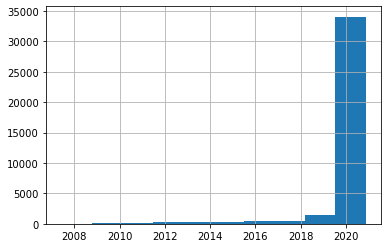

In [61]:
pd.to_datetime(train["Listed On"]).hist()

In [78]:
pd.to_datetime(train["Listed On"]).dt.year + pd.to_datetime(train["Listed On"]).dt.month/12

0        2020.583333
1        2020.500000
2        2020.750000
3        2020.500000
4        2020.333333
            ...     
37434    2020.333333
37435    2020.333333
37436    2020.333333
37437    2020.166667
37438    2020.083333
Name: Listed On, Length: 37439, dtype: float64

## City

In [213]:
train["City"].value_counts().head(100).index

Index(['Los Angeles', 'San Jose', 'San Francisco', 'San Mateo', 'Santa Clara',
       'Santa Cruz', 'Sunnyvale', 'Los Gatos', 'Morgan Hill', 'Redwood City',
       'Gilroy', 'Compton', 'Mountain View', 'Palo Alto', 'Milpitas', 'Aptos',
       'Los Altos', 'Culver City', 'West Hollywood', 'Watsonville',
       'San Carlos', 'Menlo Park', 'Beverly Hills', 'South San Francisco',
       'Cupertino', 'Pacifica', 'Saratoga', 'San Bruno', 'Scotts Valley',
       'Belmont', 'Dodgertown', 'Campbell', 'Rio Rico', 'Boulder Creek',
       'Capitola', 'Millbrae', 'Playa Vista', 'Felton', 'Sacramento', 'Tubac',
       'Berkeley', 'Portola Valley', 'Atherton', 'Soquel', 'Nogales',
       'Half Moon Bay', 'Ben Lomond', 'Fresno', 'San Martin', 'Brisbane',
       'Moss Beach', 'Glendale', 'Inglewood', 'Montara', 'Sonoita',
       'Yountville', 'Bell Gardens', 'Los Alamos', 'Somis', 'Applegate',
       'Mather', 'Delhi', 'Penryn', 'San Diego', 'Mccloud', 'Colusa',
       'Smartsville', 'Woodbridge', 'Mon

# Data Pre-Processing

In [273]:
parking_types_train = train["Parking"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()
heating_types_train = train["Heating"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()
flooring_types_train = train["Flooring"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()
appliance_types_train = train["Appliances included"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()
cities_train = train["City"].value_counts().head(200)

train_medians = train.median()
test_medians = test.median()

def preprocess_data(df, meds, ptypes_train, htypes_train, ftypes_train, atypes_train, cities):
    df["Total interior livable area"] = df["Total interior livable area"].fillna(meds["Total interior livable area"])
    
    df["Bathrooms"] = df["Bathrooms"].fillna(meds["Bathrooms"])
    
    df["Total spaces"] = df["Total spaces"].fillna(meds["Total spaces"])
    df["Total spaces"] = np.abs(np.minimum(df["Total spaces"], 30))
    
    df["High School Score"] = df["High School Score"].fillna(meds["High School Score"])
    df["High School Distance"] = df["High School Distance"].fillna(meds["High School Distance"])

    
    df["Year built"] = df["Year built"].fillna(meds["Year built"])
    df["Year built"] = np.maximum(df["Year built"], 1870)
    df["Year built"] = np.minimum(df["Year built"], 2022)
    
    df["state_ind"] = df["State"] == "CA"
    
    df["Garage spaces"] = df["Garage spaces"].fillna(meds["Garage spaces"])
    df["Garage spaces"] = np.maximum(df["Garage spaces"], 0)
    df["Garage spaces"] = np.minimum(df["Garage spaces"], 20)
    
    df["Elementary School Score"] = df["Elementary School Score"].fillna(meds["Elementary School Score"])
    
    df["Full bathrooms"] = df["Full bathrooms"].fillna(meds["Full bathrooms"])

    df["t1"] = df["Type"].str.lower().str.replace(" ", "").str.contains("singlefamily")
    df["t2"] = df["Type"].str.lower().str.replace(" ", "").str.contains("condo")
    df["t3"] = df["Type"].str.lower().str.replace(" ", "").str.contains("apartment")
    df["t4"] = df["Type"].str.lower().str.replace(" ", "").str.contains("vacant")
    df["t5"] = (df["Type"].str.lower().str.replace(" ", "").str.contains("plex")  |
                df["Type"].str.lower().str.replace(" ", "").str.contains("multifamily"))
    df["t6"] = df["Type"].str.lower().str.replace(" ", "").str.contains("townhouse")
    df["t7"] = df["Type"].str.lower().str.replace(" ", "").str.contains("mobile")
    df["t8"] = df["Type"].str.lower().str.replace(" ", "").str.contains("unknown")

    # Doesn't seem to matter which impute strategy I use
    #df["l1"] = df["Lot"].fillna(meds["Lot"])
    df["l1"] = df["Lot"].fillna(0)
    
    df["Last Sold Price"] = df["Last Sold Price"].fillna(0)
    df["Last Sold Days"] = (pd.to_datetime("1/1/2021") - pd.to_datetime(df["Last Sold On"].fillna("1/1/2021"))).dt.days
    
    df["Tax assessed value"] = df["Tax assessed value"].replace('#DIV/0!', np.NaN).astype('float').fillna(0)
    
    df["Listed On"] = pd.to_datetime(df["Listed On"]).dt.year + (pd.to_datetime(df["Listed On"]).dt.month/12)
    
    for htype in htypes_train.index:
        df[htype] = df["Heating"].str.lower().str.replace(" ", "").str.contains(htype, na=False)
    
    for ptype in ptypes_train.index:
        df[ptype] = df["Parking"].str.lower().str.replace(" ", "").str.contains(ptype, na=False)
    
    for ftype in ftypes_train.index:
        df[ftype] = df["Flooring"].str.lower().str.replace(" ", "").str.contains(ftype, na=False)

    for atype in atypes_train.index:
        df[atype] = df["Appliances included"].str.lower().str.replace(" ", "").str.contains(atype, na=False)

    for city in cities.index:
        df[city] = df["City"].str.contains(city, na=False)
        
    df["r1"] = df["Listed Price"] / (df["Last Sold Price"] + 0.1)
    df["r2"] = df["Last Sold Price"] / (df["Tax assessed value"] + 0.1)
    df["r3"] = df["Tax assessed value"] / (df["Listed Price"] + 0.1)
    
    return df

/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys
/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [274]:
train = preprocess_data(train, train_medians, parking_types_train, 
                        heating_types_train, flooring_types_train, 
                        appliance_types_train, cities_train)


/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Determine the target

In [275]:
#y = np.log(train["Sold Price"])
y = train["Sold Price"]

In [276]:
# Get this feature importance from training a model below with max_features = None. 
# Then use the top X features in a model with max_features = 'sqrt'
feat_imp_orig = feat_importances

In [277]:
pred_vars = ["Listed Price", "Total interior livable area", "Bathrooms", 
             "Year built", "High School Score", "Garage spaces", "state_ind", 
            "Elementary School Score", "Full bathrooms",
            "Total spaces", "High School Distance", "t1", "t2", "t3", "t4", "t5", "t6", "t7", "t8",
            "l1", "Last Sold Price", "Last Sold Days", "Tax assessed value", "Listed On", 
            "r1", "r2", "r3"] + list(parking_types_train.index) + list(heating_types_train.index) + list(flooring_types_train.index) + list(appliance_types_train.index) + list(cities_train.index)

#pred_vars = list(feat_imp_orig.nlargest(90).index)
# Used top 70/300
# Used top 80/360

X = train[pred_vars]

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=56)

# Models

In [303]:
params = {"n_estimators":150,
          "learning_rate":0.15,
          "max_depth":3,
          "random_state":56,
          "subsample":1,
          'max_features':None, # None or sqrt
          "loss":'squared_error'}

In [304]:
model = GradientBoostingRegressor(verbose = 1).set_params(**params)

In [305]:
model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1 2072128340456.1184           30.79s
         2 1581068032335.1519           30.47s
         3 1211485329777.8005           30.32s
         4 939914187839.7311           30.02s
         5 743025411567.6570           29.86s
         6 594690638944.1211           29.61s
         7 485936026418.9871           29.39s
         8 405657912232.2123           29.20s
         9 345606394005.1746           29.00s
        10 298380552452.6097           28.79s
        20 148454439563.0504           26.81s
        30 116870180994.6126           24.89s
        40 99878769078.0838           22.85s
        50 91705698414.9785           20.91s
        60 83997900752.7158           18.72s
        70 79379025903.6506           16.61s
        80 75758443381.4995           14.47s
        90 71096450871.7795           12.38s
       100 68128220121.2185           10.31s


GradientBoostingRegressor(learning_rate=0.15, n_estimators=150, random_state=56,
                          subsample=1, verbose=1)

In [306]:
model.score(X_test, y_test)
# 0.8933560638624833

0.8929916675516629

<AxesSubplot:>

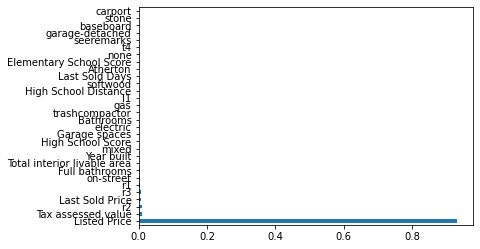

In [307]:
feat_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)
feat_importances.nlargest(30).plot(kind='barh')

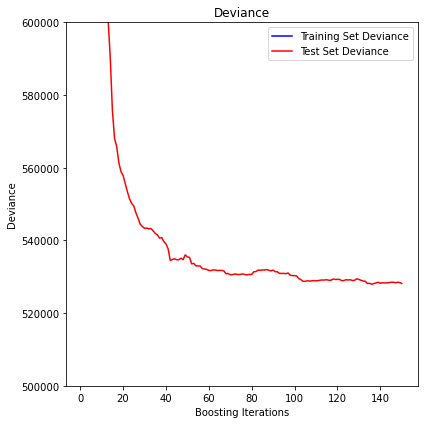

527945.0997559888


In [308]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    #test_score[i] = model.loss_(y_test, y_pred)   # This is just squared error
    test_score[i] = np.sqrt(((y_pred - y_test) ** 2).mean())  # this is RMSE

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1, model.train_score_,
    "b-", label="Training Set Deviance",
)
plt.plot(np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance")
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
#plt.ylim(0.03, 0.06)
plt.ylim(5e5, 6e5)
fig.tight_layout()
plt.show()
print(np.min(test_score))

# 525735.7499996236

In [250]:
errs = y_pred - y_test

In [251]:
erratio = y_pred / y_test

In [252]:
erratio[erratio > 5]

2381     20.338858
11533     7.242987
13039     5.558858
24706     6.124587
7251      5.693587
37377     5.067696
16999     6.246150
13336     5.628927
26779     6.049610
4099      8.971166
19848     6.217476
32682     6.876804
1297      9.033146
3014      6.953358
15292     5.682314
11211     8.731590
37149     5.373809
33480     5.413897
8117      6.081868
Name: Sold Price, dtype: float64

In [199]:
X_test[errs > 1e6].join(train["Sold Price"])[["Listed Price", "Sold Price", "Last Sold Price", "Last Sold Days"]]



,Listed Price,Sold Price,Last Sold Price,Last Sold Days
2381,0,133000,0.0,773
11533,16094000,1726000,0.0,0
31772,7064000,6082000,5300000.0,2051
2941,5176888,3344000,0.0,0
17139,19170000,10935000,6925000.0,563
...,...,...,...,...
27856,17592000,14321000,15600000.0,966
23596,18898000,10455000,0.0,0
33480,1601000,293000,1560000.0,1912
12333,1474000,366000,1733000.0,928


In [204]:
train.iloc[2381].head(50)

Id                                                                          2381
Sold Price                                                                133000
Summary                        Stunning 4 bed/3.5 two story Craftsman style h...
Type                                                                SingleFamily
Year built                                                                1949.0
Heating                                                               Forced air
Cooling                                                                    Other
Parking                                       Garage, Garage - Attached, Covered
Lot                                                                       8280.0
Bedrooms                       Ground Floor Bedroom, Master Bedroom on Ground...
Bathrooms                                                                    4.0
Full bathrooms                                                               3.0
Total interior livable area 

# Hyperparameter Optimization

In [130]:
BayesSearchCV?

In [135]:
opt = BayesSearchCV(
    GradientBoostingRegressor(random_state = 56,loss = 'squared_error'),
    {
        'n_estimators': (50, 1000),
        'learning_rate': (1e-5, .9, 'log-uniform'),
        'max_depth': (2, 6),  # integer valued parameter
        'subsample': (0.05, 1.0, 'uniform')
    },
    n_iter = 3,
    cv = 3,
    verbose = 1
)

In [136]:
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.014131016106847008, max_depth=5, n_estimators=877, subsample=0.6061170574516013; total time=  11.3s
[CV] END learning_rate=0.014131016106847008, max_depth=5, n_estimators=877, subsample=0.6061170574516013; total time=  12.2s
[CV] END learning_rate=0.014131016106847008, max_depth=5, n_estimators=877, subsample=0.6061170574516013; total time=  12.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.0057898007469251046, max_depth=2, n_estimators=94, subsample=0.8073876549562713; total time=   0.7s
[CV] END learning_rate=0.0057898007469251046, max_depth=2, n_estimators=94, subsample=0.8073876549562713; total time=   0.7s
[CV] END learning_rate=0.0057898007469251046, max_depth=2, n_estimators=94, subsample=0.8073876549562713; total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.00016189871380357706, max_depth=6, n_estimators=

BayesSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=56),
              n_iter=3,
              search_spaces={'learning_rate': (1e-05, 0.9, 'log-uniform'),
                             'max_depth': (2, 6), 'n_estimators': (50, 1000),
                             'subsample': (0.05, 1.0, 'uniform')},
              verbose=2)

In [35]:
opt.score(X_test, y_test)

# 0.930401 with no subsampling
# 0.929161025403613 with subsampling, 50 iterations


0.9301608507840881

In [36]:
opt.best_estimator_.max_depth, opt.best_estimator_.learning_rate, opt.best_estimator_.n_estimators, opt.best_estimator_.subsample

# (4, 0.019076781177538346, 500, 1.0) with no subsampling
# (5, 0.011876032175591269, 376, 0.44775503528274996) with subsampling (50 iterations)


(4, 0.012474997352881075, 614, 0.3871953641896431)

In [38]:
params["max_depth"] = opt.best_estimator_.max_depth
params["learning_rate"] = opt.best_estimator_.learning_rate
params["n_estimators"] = opt.best_estimator_.n_estimators
params["subsample"] = opt.best_estimator_.subsample

In [99]:
GradientBoostingRegressor?

# Train final model
Use all the data

In [309]:
print(params)
print(pred_vars), len(pred_vars)

{'n_estimators': 150, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 56, 'subsample': 1, 'max_features': None, 'loss': 'squared_error'}
['Listed Price', 'Total interior livable area', 'Bathrooms', 'Year built', 'High School Score', 'Garage spaces', 'state_ind', 'Elementary School Score', 'Full bathrooms', 'Total spaces', 'High School Distance', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 'l1', 'Last Sold Price', 'Last Sold Days', 'Tax assessed value', 'Listed On', 'r1', 'r2', 'r3', 'garage', 'covered', 'garage-attached', 'driveway', 'carport', 'garagedooropener', '0spaces', 'sidebyside', 'attached', 'garage-detached', 'garage-twodoor', 'off-street', 'onsite(singlefamilyonly)', 'interioraccess', 'independent', 'assigned', 'onsite', 'concrete', 'communitystructure', 'tandem', 'gated', 'on-street', 'guest', 'garage-singledoor', 'enclosed', 'underground/basement', 'private', 'none', 'controlledentrance', 'directaccess', 'detachedcarport', 'onsite-mapped(condoonly)', 'onstreet',

(None, 648)

In [310]:
model = GradientBoostingRegressor().set_params(**params).fit(X, y)

# Make Predictions

Do the same pre-processing on the test data that we do on the train data

In [311]:
test = preprocess_data(test, train_medians, parking_types_train, 
                       heating_types_train, flooring_types_train, 
                       appliance_types_train, cities_train)

/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [312]:
test["Sold Price"] = model.predict(test[pred_vars])

In [313]:
test[["Id", "Sold Price"]].to_csv("../submission.csv", index = False)

# Ideas

Things to try out for the future:
 - Target Ideas:
  - Target is log of the price
  - Target is the actual dollar of sale price (GOLD STAR - THIS WORKS BETTER THAN LOG PRICE)
  - Target is the difference between the price and the list price
  
 - Variable Ideas:
  - Get a home price index and map to list date?
  - Do something with summary, sentiment analysis?

<AxesSubplot:>

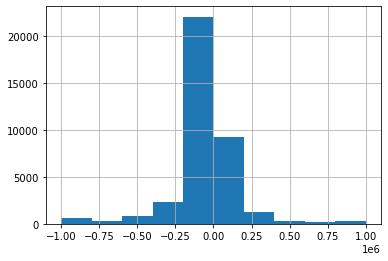

In [621]:
np.minimum(np.maximum(train["Sold Price"] - train["Listed Price"], -1e6), 1e6).hist()